## 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(action='ignore') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tqdm import tqdm 
import pandas as pd 
import numpy as np
from collections import defaultdict

def get_fft(input_filename,chunksize = 10544):
  fft_list = []  
  df = pd.read_csv(input_filename, chunksize = chunksize,index_col=0)
  for i,df_chunk in tqdm(enumerate(df)):
    if len(df_chunk) != chunksize : break
    fft_c1 = np.fft.fft(df_chunk.iloc[:,0])[:chunksize//2]/chunksize * 2
    fft_c2 = np.fft.fft(df_chunk.iloc[:,1])[:chunksize//2]/chunksize * 2
    fft_list.append(np.abs(np.hstack([fft_c1,fft_c2])))
    assert len(fft_list[-1])==chunksize
  return fft_list

def get_fft_dict(phmap_train):
    fft_dict = defaultdict(list)
    for name in phmap_train:
      file_path = f'/content/drive/MyDrive/phmap_train/train_{name}.csv'
      label = name.split('_')[-1]
      print(label)
      fft_dict[label] += get_fft(file_path)
    for key in fft_dict:
      fft_dict[key] = np.array(fft_dict[key])
    return fft_dict
    
def select_index(raw_data_dict,q):
    selected_index = []
    for label in raw_data_dict:
        raw_data = raw_data_dict[label]
        N = len(raw_data[0])
        sum_fft_c1 = np.sum(raw_data[:,:N//2],axis=0)
        sum_fft_c2 = np.sum(raw_data[:,N//2:],axis=0)
        th_c1 = np.quantile(sum_fft_c1,q)
        th_c2 = np.quantile(sum_fft_c2,q)
        selected_index += list(np.where(sum_fft_c1>th_c1)[0])
        selected_index += list(np.where(sum_fft_c2>th_c2)[0]+N//2)
    selected_index = sorted(list(set(selected_index)))
    return selected_index

def get_selected_data(raw_data_dict,selected_index):
  selected_data = []
  label_list = []
  for label in raw_data_dict:
      raw_data = raw_data_dict[label][:,selected_index]
      selected_data.append(raw_data)
      label_list += [label]*len(raw_data)
  selected_data = np.vstack(selected_data)
  return selected_data,label_list

In [ ]:
# 1일차 데이터를 예측
day1_data = get_fft_dict(['1st_Normal', '1st_Bearing', '1st_Unbalance', '1st_Looseness', '1st_high'])
day23_data = get_fft_dict(['2nd_Bearing', '2nd_Looseness', '2nd_Unbalance', '3rd_Normal', '3rd_Unbalance'])
selected_index = select_index(day1_data,0.5)
selected_data,label_list = get_selected_data(day1_data,selected_index)
selected_data_23,label_list_23 = get_selected_data(day23_data,selected_index)

x_train= selected_data
y_train= label_list
x_test= selected_data_23
y_test= label_list_23

# x_train= selected_data_23
# y_train= label_list_23
# x_test= selected_data
# y_test= label_list

Normal


1485it [00:45, 32.30it/s]


Bearing


1800it [00:36, 49.56it/s]


Unbalance


1117it [00:21, 51.52it/s]


Looseness


609it [00:13, 43.95it/s]


high


415it [00:12, 32.80it/s]


Bearing


3890it [01:16, 50.92it/s]


Looseness


3069it [01:01, 49.51it/s]


Unbalance


2853it [00:59, 47.57it/s]


Normal


5017it [01:50, 45.59it/s]


Unbalance


2239it [00:47, 46.79it/s]


In [ ]:
# 1일차 데이터에 대한 예측
from sklearn.model_selection import train_test_split
train_data = get_fft_dict(['1st_Normal', '1st_Bearing', '1st_Unbalance', '1st_Looseness', '1st_high',
                           '2nd_Bearing', '2nd_Looseness', '2nd_Unbalance', '3rd_Normal', '3rd_Unbalance'])
selected_index = select_index(train_data,0.5)
selected_data,label_list = get_selected_data(train_data,selected_index)
X = selected_data
y = label_list
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Normal


1485it [00:23, 62.86it/s]


Bearing


1800it [00:31, 56.46it/s]


Unbalance


1117it [00:18, 61.07it/s]


Looseness


609it [00:11, 54.29it/s]


high


415it [00:06, 61.78it/s]


Bearing


3890it [01:06, 58.77it/s]


Looseness


3069it [00:53, 57.18it/s]


Unbalance


2853it [00:47, 59.81it/s]


Normal


5017it [01:25, 59.01it/s]


Unbalance


2239it [00:39, 57.17it/s]


### 위 내용 테스트 코드

In [ ]:
np.quantile(np.sum(fft_dict['1st_Normal'][:,:10544//2],axis=0),0.75),np.quantile(np.sum(fft_dict['1st_Normal'][:,:10544//2],axis=0),0.25)

(5.990378116565684, 1.2034000908815536)

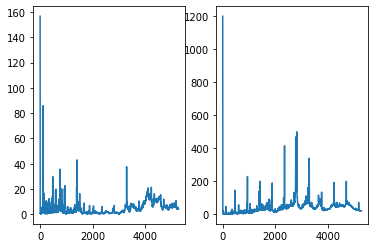

In [ ]:
plt.subplot(121).plot(np.sum(fft_dict['1st_Normal'][:,:10544//2],axis=0))
plt.subplot(122).plot(np.sum(fft_dict['1st_Normal'][:,10544//2:],axis=0))
plt.show()

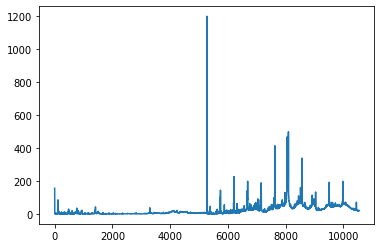

In [ ]:
plt.plot(np.sum(fft_dict['1st_Normal'],axis=0))
plt.show()

In [ ]:
# tN_spec_c1 = np.vstack([fft_dict['1st_Normal_c1'],fft_dict['3rd_Normal_c1']])
# tB_spec_c1 = np.vstack([fft_dict['1st_Bearing_c1'],fft_dict['2nd_Bearing_c1']])
# tU_spec_c1 = np.vstack([fft_dict['1st_Unbalance_c1'],fft_dict['2nd_Unbalance_c1'],fft_dict['3rd_Unbalance_c1']])
# tL_spec_c1 = np.vstack([fft_dict['1st_Looseness_c1'],fft_dict['2nd_Looseness_c1']])
# tH_spec_c1 = fft_dict['1st_high_c1']

# tN_spec_c2 = np.vstack([fft_dict['1st_Normal_c2'],fft_dict['3rd_Normal_c2']])
# tB_spec_c2 = np.vstack([fft_dict['1st_Bearing_c2'],fft_dict['2nd_Bearing_c2']])
# tU_spec_c2 = np.vstack([fft_dict['1st_Unbalance_c2'],fft_dict['2nd_Unbalance_c2'],fft_dict['3rd_Unbalance_c2']])
# tL_spec_c2 = np.vstack([fft_dict['1st_Looseness_c2'],fft_dict['2nd_Looseness_c2']])
# tH_spec_c2 = fft_dict['1st_high_c2']

In [ ]:
train_1st_Bearing = '/content/drive/MyDrive/phmap_train/train_1st_Bearing.csv'
train_1st_Looseness = '/content/drive/MyDrive/phmap_train/train_1st_Looseness.csv'
train_1st_Normal = '/content/drive/MyDrive/phmap_train/train_1st_Normal.csv'
train_1st_Unbalance = '/content/drive/MyDrive/phmap_train/train_1st_Unbalance.csv'
train_1st_high = '/content/drive/MyDrive/phmap_train/train_1st_high.csv'
train_2nd_Bearing = '/content/drive/MyDrive/phmap_train/train_2nd_Bearing.csv'
train_2nd_Looseness = '/content/drive/MyDrive/phmap_train/train_2nd_Looseness.csv'
train_2nd_Unbalance = '/content/drive/MyDrive/phmap_train/train_2nd_Unbalance.csv'
train_3rd_Normal = '/content/drive/MyDrive/phmap_train/train_3rd_Normal.csv'
train_3rd_Unbalance = '/content/drive/MyDrive/phmap_train/train_3rd_Unbalance.csv'

## 벡터를 사용하여 시각화

### 스펙트로그램 식 인덱스 추출을 위한 데이터

In [ ]:
from tqdm import tqdm 


def get_fft(input_filename, column_name):
  fft_list = []
  df = pd.read_csv(input_filename, chunksize = 10544)
  for i,df_c in tqdm(enumerate(df)):
    if len(df_c) != 10544 : break
    x = np.array(df_c.iloc[:,0])
    y = np.array(df_c[column_name])
    nfft = len(x) 
    fft_y = np.fft.fft(y)/nfft * 2 
    fft_y = list(fft_y)
    fft_list.append(fft_y)
  fft_list = np.array(fft_list)
  return fft_list

column_name = '1st_Normal_c1'
fft_dict = {}
fft_dict[column_name] = get_fft(train_1st_Normal, column_name)




1485it [00:21, 67.57it/s]


In [ ]:
fft_dict['1st_Bearing_c1'] = get_fft(train_1st_Bearing, '1st_Bearing_c1')

1469it [00:18, 78.92it/s]

In [ ]:
np.shape(fft_dict['1st_Bearing_c1'])

In [ ]:
np.shape(fft_dict[column_name])

(1485, 10544)

In [ ]:
get_fft(train_1st_Bearing, '1st_Bearing_c1')

1800it [00:30, 59.59it/s]


array([[ 3.81634729e-01+9.43436865e-18j, -4.03552031e-03-2.68175792e-03j,
         4.60379770e-03-3.79520064e-03j, ...,
        -6.41402244e-03-2.70874289e-03j,  4.60379770e-03+3.79520064e-03j,
        -4.03552031e-03+2.68175792e-03j],
       [ 3.68439605e-01-6.73883475e-18j, -2.32891002e-04-6.11529970e-03j,
        -2.91020640e-05-3.97245793e-03j, ...,
         8.64737811e-04-1.92647238e-03j, -2.91020640e-05+3.97245793e-03j,
        -2.32891002e-04+6.11529970e-03j],
       [ 3.72442973e-01+8.76048517e-18j, -5.78785136e-05+9.64473525e-03j,
         2.83855595e-03+1.26282579e-03j, ...,
        -1.45895252e-03+1.11766512e-03j,  2.83855595e-03-1.26282579e-03j,
        -5.78785136e-05-9.64473525e-03j],
       ...,
       [ 4.56065575e-01+5.39106780e-18j,  9.45961794e-03+2.84769444e-04j,
        -5.67321768e-04+1.29923710e-03j, ...,
         2.26039103e-04-6.93600227e-03j, -5.67321768e-04-1.29923710e-03j,
         9.45961794e-03-2.84769444e-04j],
       [ 4.49962701e-01-3.16725233e-17j,  7.

array([0.10958042, 0.00024852, 0.00029072, ..., 0.01358989, 0.01343421,
       0.00558731])

c1

In [ ]:
import numpy as np 
import math
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev


t1N = pd.read_csv(train_1st_Normal, chunksize = 10544)

t1N_spec_c1 = []


for i,df1 in enumerate(t1N):
  if len(df1) < 10544: break
  x = np.array(df1.iloc[:,0])
  y = np.array(df1['1st_Normal_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1N_spec_c1.append(fft_y)

In [ ]:
t1N_spec_c1[0]

In [ ]:
t1B = pd.read_csv(train_1st_Bearing, chunksize = 10544)

t1B_spec_c1 = []

for i,df2 in enumerate(t1B):
  if len(df2) < 10544: break
  x = np.array(df2.iloc[:,0])
  y = np.array(df2['1st_Bearing_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1B_spec_c1.append(fft_y)
  if i == 1798: break

In [ ]:
t1U = pd.read_csv(train_1st_Unbalance, chunksize = 10544)

t1U_spec_c1 = []

for i,df3 in enumerate(t1U):
  if len(df3) < 10544: break
  x = np.array(df3.iloc[:,0])
  y = np.array(df3['1st_Unbalance_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1U_spec_c1.append(fft_y)



In [ ]:
np.shape(t1U_spec_c1)

(1117, 10544)

In [ ]:
df3.shape

(2108, 3)

In [ ]:
t1L = pd.read_csv(train_1st_Looseness, chunksize = 10544)

t1L_spec_c1 = []

for i,df4 in enumerate(t1L):
  if len(df4) < 10544: break
  x = np.array(df4.iloc[:,0])
  y = np.array(df4['1st_Looseness_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1L_spec_c1.append(fft_y)

In [ ]:
t1H = pd.read_csv(train_1st_high, chunksize = 10544)

t1H_spec_c1 = []

for i,df5 in enumerate(t1H):
  if len(df3) < 10544: break
  x = np.array(df5.iloc[:,0])
  y = np.array(df5['1st_high_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1H_spec_c1.append(fft_y)

In [ ]:
t2B = pd.read_csv(train_2nd_Bearing, chunksize = 10544)

t2B_spec_c1 = []

for i,df6 in enumerate(t2B):
  if len(df6) < 10544: break
  x = np.array(df6.iloc[:,0])
  y = np.array(df6['2nd_Bearing_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t2B_spec_c1.append(fft_y)

In [ ]:
t2L = pd.read_csv(train_2nd_Looseness, chunksize = 10544)

t2L_spec_c1 = []

for i,df7 in enumerate(t2L):
  if len(df7) < 10544: break
  x = np.array(df7.iloc[:,0])
  y = np.array(df7['2nd_Looseness_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t2L_spec_c1.append(fft_y)

In [ ]:
t2U = pd.read_csv(train_2nd_Unbalance, chunksize = 10544)

t2U_spec_c1 = []

for i,df8 in enumerate(t2U):
  if len(df8) < 10544: break
  x = np.array(df8.iloc[:,0])
  y = np.array(df8['2nd_Unbalance_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t2U_spec_c1.append(fft_y)

In [ ]:
t3N = pd.read_csv(train_3rd_Normal, chunksize = 10544)

t3N_spec_c1 = []

for i,df9 in enumerate(t3N):
  if len(df9) < 10544: break
  x = np.array(df9.iloc[:,0])
  y = np.array(df9['3rd_Normal_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t3N_spec_c1.append(fft_y)

In [ ]:
t3U = pd.read_csv(train_3rd_Unbalance, chunksize = 10544)

t3U_spec_c1 = []

for i,df10 in enumerate(t3U):
  if len(df10) < 10544: break
  x = np.array(df10.iloc[:,0])
  y = np.array(df10['3rd_Unbalance_c1'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t3U_spec_c1.append(fft_y)

c2

In [ ]:
import numpy as np 
import math
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev


t1N = pd.read_csv(train_1st_Normal, chunksize = 10544)

t1N_spec_c2 = []

for i,df1 in enumerate(t1N):
  if len(df1) < 10544: break
  x = np.array(df1.iloc[:,0])
  y = np.array(df1['1st_Normal_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1N_spec_c2.append(fft_y)

In [ ]:
t1B = pd.read_csv(train_1st_Bearing, chunksize = 10544)

t1B_spec_c2 = []

for i,df2 in enumerate(t1B):
  if len(df3) < 10544: break
  x = np.array(df2.iloc[:,0])
  y = np.array(df2['1st_Bearing_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1B_spec_c2.append(fft_y)

In [ ]:
t1U = pd.read_csv(train_1st_Unbalance, chunksize = 10544)

t1U_spec_c2 = []

for i,df3 in enumerate(t1U):
  if len(df3) < 10544: break
  x = np.array(df3.iloc[:,0])
  y = np.array(df3['1st_Unbalance_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1U_spec_c2.append(fft_y)

In [ ]:
t1L = pd.read_csv(train_1st_Looseness, chunksize = 10544)

t1L_spec_c2 = []

for i,df4 in enumerate(t1L):
  if len(df3) < 10544: break
  x = np.array(df4.iloc[:,0])
  y = np.array(df4['1st_Looseness_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1L_spec_c2.append(fft_y)

In [ ]:
t1H = pd.read_csv(train_1st_high, chunksize = 10544)

t1H_spec_c2 = []

for i,df5 in enumerate(t1H):
  if len(df3) < 10544: break
  x = np.array(df5.iloc[:,0])
  y = np.array(df5['1st_high_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t1H_spec_c2.append(fft_y)

In [ ]:
t2B = pd.read_csv(train_2nd_Bearing, chunksize = 10544)

t2B_spec_c2 = []

for i,df6 in enumerate(t2B):
  if len(df3) < 10544: break
  x = np.array(df6.iloc[:,0])
  y = np.array(df6['2nd_Bearing_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t2B_spec_c2.append(fft_y)

In [ ]:
t2L = pd.read_csv(train_2nd_Looseness, chunksize = 10544)

t2L_spec_c2 = []

for i,df7 in enumerate(t2L):
  if len(df3) < 10544: break
  x = np.array(df7.iloc[:,0])
  y = np.array(df7['2nd_Looseness_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t2L_spec_c2.append(fft_y)

In [ ]:
t2U = pd.read_csv(train_2nd_Unbalance, chunksize = 10544)

t2U_spec_c2 = []

for i,df8 in enumerate(t2U):
  if len(df3) < 10544: break
  x = np.array(df8.iloc[:,0])
  y = np.array(df8['2nd_Unbalance_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t2U_spec_c2.append(fft_y)

In [ ]:
t3N = pd.read_csv(train_3rd_Normal, chunksize = 10544)

t3N_spec_c2 = []

for i,df9 in enumerate(t3N):
  if len(df3) < 10544: break
  x = np.array(df9.iloc[:,0])
  y = np.array(df9['3rd_Normal_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t3N_spec_c2.append(fft_y)

In [ ]:
t3U = pd.read_csv(train_3rd_Unbalance, chunksize = 10544)

t3U_spec_c2 = []

for i,df10 in enumerate(t3U):
  if len(df3) < 10544: break
  x = np.array(df10.iloc[:,0])
  y = np.array(df10['3rd_Unbalance_c2'])

  nfft = len(x) 
  fft_y = np.fft.fft(y)/nfft * 2 
  fft_y = list(fft_y)
  t3U_spec_c2.append(fft_y)

## 같은 클래스 데이터셋 병합하기

In [ ]:
t1N_spec_c1 = t1N_spec_c1 + t3N_spec_c1
t1B_spec_c1 = t1B_spec_c1 + t2B_spec_c1
t1U_spec_c1 = t1U_spec_c1 + t2U_spec_c1 + t3U_spec_c1
t1L_spec_c1 = t1L_spec_c1 + t2L_spec_c1

t1N_spec_c2 = t1N_spec_c2 + t3N_spec_c2
t1B_spec_c2 = t1B_spec_c2 + t2B_spec_c2
t1U_spec_c2 = t1U_spec_c2 + t2U_spec_c2 + t3U_spec_c2
t1L_spec_c2 = t1L_spec_c2 + t2L_spec_c2

In [ ]:
t1N_spec_test = t1N_spec_c1 + t3N_spec_c1

In [ ]:
pd.DataFrame(t1N_spec_c1)

,0,1,2,3,4,5,6,7,8,9,...,10534,10535,10536,10537,10538,10539,10540,10541,10542,10543
0,0.109580+0.000000j,0.000048+0.000244j,-0.000290-0.000018j,-0.000261+0.000048j,-0.000158+0.000148j,-0.000234+0.000102j,-0.000239+0.000082j,-0.000302-0.000330j,-0.000249-0.000273j,-0.000236-0.000097j,...,-0.000036+0.000002j,-0.000236+0.000097j,-0.000249+0.000273j,-0.000302+0.000330j,-0.000239-0.000082j,-0.000234-0.000102j,-0.000158-0.000148j,-0.000261-0.000048j,-0.000290+0.000018j,0.000048-0.000244j
1,0.111262+0.000000j,0.000073+0.000194j,0.000079-0.000039j,0.000060+0.000174j,0.000239-0.000020j,0.000162+0.000108j,0.000040-0.000152j,-0.000187-0.000407j,-0.000071+0.000360j,0.000065+0.000119j,...,0.000053-0.000072j,0.000065-0.000119j,-0.000071-0.000360j,-0.000187+0.000407j,0.000040+0.000152j,0.000162-0.000108j,0.000239+0.000020j,0.000060-0.000174j,0.000079+0.000039j,0.000073-0.000194j
2,0.115813+0.000000j,-0.000427+0.002399j,-0.000047+0.000097j,-0.000497+0.000919j,0.000052+0.000329j,-0.000543+0.000898j,-0.000063-0.000419j,-0.000797+0.000412j,-0.000548-0.000147j,-0.000076+0.000104j,...,0.000080-0.000567j,-0.000076-0.000104j,-0.000548+0.000147j,-0.000797-0.000412j,-0.000063+0.000419j,-0.000543-0.000898j,0.000052-0.000329j,-0.000497-0.000919j,-0.000047-0.000097j,-0.000427-0.002399j
3,0.114525+0.000000j,0.001042-0.000745j,0.000087-0.001016j,-0.000311-0.000769j,-0.000649-0.000350j,-0.000179-0.000210j,-0.000297-0.000381j,-0.000345+0.000800j,-0.000072+0.000256j,-0.000049+0.000052j,...,-0.000146-0.000292j,-0.000049-0.000052j,-0.000072-0.000256j,-0.000345-0.000800j,-0.000297+0.000381j,-0.000179+0.000210j,-0.000649+0.000350j,-0.000311+0.000769j,0.000087+0.001016j,0.001042+0.000745j
4,0.114845+0.000000j,0.000211+0.000487j,0.000049+0.000028j,0.000292-0.000051j,0.000371+0.000109j,0.000152-0.000062j,0.000330+0.000033j,0.000333+0.000144j,0.000329+0.000336j,0.000200+0.000058j,...,0.000425-0.000037j,0.000200-0.000058j,0.000329-0.000336j,0.000333-0.000144j,0.000330-0.000033j,0.000152+0.000062j,0.000371-0.000109j,0.000292+0.000051j,0.000049-0.000028j,0.000211-0.000487j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0.104820+0.000000j,-0.000564-0.000329j,-0.000399-0.000104j,-0.000374+0.000119j,-0.000374-0.000089j,-0.000416-0.000209j,-0.000398+0.000107j,-0.000280+0.000624j,0.000025-0.000090j,-0.000523-0.000094j,...,-0.000073+0.000042j,-0.000523+0.000094j,0.000025+0.000090j,-0.000280-0.000624j,-0.000398-0.000107j,-0.000416+0.000209j,-0.000374+0.000089j,-0.000374-0.000119j,-0.000399+0.000104j,-0.000564+0.000329j
381,0.104286+0.000000j,-0.000282+0.000071j,-0.000512+0.000235j,-0.000441-0.000037j,-0.000273+0.000042j,-0.000493+0.000008j,-0.000458-0.000136j,0.000026+0.000281j,-0.000107+0.000039j,-0.000301+0.000011j,...,-0.000173-0.000116j,-0.000301-0.000011j,-0.000107-0.000039j,0.000026-0.000281j,-0.000458+0.000136j,-0.000493-0.000008j,-0.000273-0.000042j,-0.000441+0.000037j,-0.000512-0.000235j,-0.000282-0.000071j
382,0.106349+0.000000j,0.000439+0.000202j,0.000376+0.000088j,0.000444+0.000214j,0.000196+0.000243j,0.000425+0.000312j,0.000390+0.000475j,0.000828-0.000370j,-0.000097-0.000133j,0.000275+0.000224j,...,0.000135-0.000321j,0.000275-0.000224j,-0.000097+0.000133j,0.000828+0.000370j,0.000390-0.000475j,0.000425-0.000312j,0.000196-0.000243j,0.000444-0.000214j,0.000376-0.000088j,0.000439-0.000202j
383,0.109219+0.000000j,-0.000589-0.001088j,0.000800-0.000943j,0.000096+0.000230j,0.000091-0.000105j,0.000860-0.000089j,0.000611-0.000466j,-0.000469-0.000195j,0.000038-0.000660j,-0.000071+0.000070j,...,-0.000223+0.000348j,-0.000071-0.000070j,0.000038+0.000660j,-0.000469+0.000195j,0.000611+0.000466j,0.000860+0.000089j,0.000091+0.000105j,0.000096-0.000230j,0.000800+0.000943j,-0.000589+0.001088j


In [ ]:
pd.DataFrame(t3N_spec_c1)

,0,1,2,3,4,5,6,7,8,9,...,10534,10535,10536,10537,10538,10539,10540,10541,10542,10543
0,0.669239+0.000000j,0.000104-0.000275j,-0.000074-0.000250j,-0.000100+0.000091j,-0.000140-0.000034j,-0.000302-0.000203j,-0.000120+0.000133j,-0.000693+0.000449j,0.000005-0.000234j,0.000075+0.000035j,...,-0.000276+0.000034j,0.000075-0.000035j,0.000005+0.000234j,-0.000693-0.000449j,-0.000120-0.000133j,-0.000302+0.000203j,-0.000140+0.000034j,-0.000100-0.000091j,-0.000074+0.000250j,0.000104+0.000275j
1,0.672534+0.000000j,0.000921+0.002373j,-0.000145+0.000712j,0.000174+0.001130j,-0.000519+0.000143j,0.000020+0.000383j,-0.000425-0.000314j,0.000022+0.000514j,-0.000166+0.000690j,-0.000045-0.000254j,...,0.000369-0.000048j,-0.000045+0.000254j,-0.000166-0.000690j,0.000022-0.000514j,-0.000425+0.000314j,0.000020-0.000383j,-0.000519-0.000143j,0.000174-0.001130j,-0.000145-0.000712j,0.000921-0.002373j
2,0.674939+0.000000j,-0.000097-0.000022j,-0.000104-0.000049j,-0.000035+0.000067j,-0.000295-0.000088j,-0.000246+0.000156j,-0.000019-0.000028j,-0.000233-0.000128j,-0.000019+0.000367j,-0.000088+0.000131j,...,-0.000044-0.000037j,-0.000088-0.000131j,-0.000019-0.000367j,-0.000233+0.000128j,-0.000019+0.000028j,-0.000246-0.000156j,-0.000295+0.000088j,-0.000035-0.000067j,-0.000104+0.000049j,-0.000097+0.000022j
3,0.674657+0.000000j,0.000130-0.000486j,0.000268-0.000219j,0.000036-0.000167j,0.000272-0.000231j,0.000193+0.000091j,0.000170-0.000263j,-0.000573+0.000149j,0.000470+0.000426j,0.000334-0.000540j,...,0.000157+0.000377j,0.000334+0.000540j,0.000470-0.000426j,-0.000573-0.000149j,0.000170+0.000263j,0.000193-0.000091j,0.000272+0.000231j,0.000036+0.000167j,0.000268+0.000219j,0.000130+0.000486j
4,0.673224+0.000000j,0.000023+0.000646j,-0.000015-0.000075j,-0.000103-0.000083j,-0.000037+0.000152j,0.000094+0.000003j,-0.000204-0.000304j,-0.000764-0.000673j,0.000043-0.000018j,0.000505+0.000222j,...,0.000137+0.000017j,0.000505-0.000222j,0.000043+0.000018j,-0.000764+0.000673j,-0.000204+0.000304j,0.000094-0.000003j,-0.000037-0.000152j,-0.000103+0.000083j,-0.000015+0.000075j,0.000023-0.000646j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,0.458579+0.000000j,0.000036-0.000079j,-0.000162-0.000030j,0.000093-0.000054j,-0.000056-0.000035j,0.000074+0.000384j,0.000056-0.000009j,-0.000410+0.000020j,-0.000037+0.000170j,-0.000112-0.000161j,...,-0.000056-0.000043j,-0.000112+0.000161j,-0.000037-0.000170j,-0.000410-0.000020j,0.000056+0.000009j,0.000074-0.000384j,-0.000056+0.000035j,0.000093+0.000054j,-0.000162+0.000030j,0.000036+0.000079j
383,0.457994+0.000000j,-0.000788-0.000325j,-0.000691-0.000276j,-0.000480-0.000252j,-0.000339-0.000237j,-0.000260-0.000365j,-0.000179-0.000434j,0.000272-0.000311j,-0.000311-0.000138j,0.000025-0.000258j,...,0.000032+0.000117j,0.000025+0.000258j,-0.000311+0.000138j,0.000272+0.000311j,-0.000179+0.000434j,-0.000260+0.000365j,-0.000339+0.000237j,-0.000480+0.000252j,-0.000691+0.000276j,-0.000788+0.000325j
384,0.452799+0.000000j,0.001333+0.001178j,0.000013+0.001223j,-0.000295+0.000309j,0.000258-0.000076j,0.000556+0.000246j,0.000109+0.000499j,-0.000648+0.000603j,0.000431+0.000188j,0.000394+0.000174j,...,0.000141-0.000440j,0.000394-0.000174j,0.000431-0.000188j,-0.000648-0.000603j,0.000109-0.000499j,0.000556-0.000246j,0.000258+0.000076j,-0.000295-0.000309j,0.000013-0.001223j,0.001333-0.001178j
385,0.451730+0.000000j,0.000901-0.001688j,-0.000621-0.000904j,-0.000234+0.000165j,0.000449-0.000018j,0.000272-0.000394j,0.000169-0.000561j,-0.000365+0.000243j,-0.000384-0.000503j,-0.000381-0.000146j,...,-0.000277-0.000177j,-0.000381+0.000146j,-0.000384+0.000503j,-0.000365-0.000243j,0.000169+0.000561j,0.000272+0.000394j,0.000449+0.000018j,-0.000234-0.000165j,-0.000621+0.000904j,0.000901+0.001688j


In [ ]:
pd.DataFrame(t1N_spec_test)

,0,1,2,3,4,5,6,7,8,9,...,10534,10535,10536,10537,10538,10539,10540,10541,10542,10543
0,0.109580+0.000000j,0.000048+0.000244j,-0.000290-0.000018j,-0.000261+0.000048j,-0.000158+0.000148j,-0.000234+0.000102j,-0.000239+0.000082j,-0.000302-0.000330j,-0.000249-0.000273j,-0.000236-0.000097j,...,-0.000036+0.000002j,-0.000236+0.000097j,-0.000249+0.000273j,-0.000302+0.000330j,-0.000239-0.000082j,-0.000234-0.000102j,-0.000158-0.000148j,-0.000261-0.000048j,-0.000290+0.000018j,0.000048-0.000244j
1,0.111262+0.000000j,0.000073+0.000194j,0.000079-0.000039j,0.000060+0.000174j,0.000239-0.000020j,0.000162+0.000108j,0.000040-0.000152j,-0.000187-0.000407j,-0.000071+0.000360j,0.000065+0.000119j,...,0.000053-0.000072j,0.000065-0.000119j,-0.000071-0.000360j,-0.000187+0.000407j,0.000040+0.000152j,0.000162-0.000108j,0.000239+0.000020j,0.000060-0.000174j,0.000079+0.000039j,0.000073-0.000194j
2,0.115813+0.000000j,-0.000427+0.002399j,-0.000047+0.000097j,-0.000497+0.000919j,0.000052+0.000329j,-0.000543+0.000898j,-0.000063-0.000419j,-0.000797+0.000412j,-0.000548-0.000147j,-0.000076+0.000104j,...,0.000080-0.000567j,-0.000076-0.000104j,-0.000548+0.000147j,-0.000797-0.000412j,-0.000063+0.000419j,-0.000543-0.000898j,0.000052-0.000329j,-0.000497-0.000919j,-0.000047-0.000097j,-0.000427-0.002399j
3,0.114525+0.000000j,0.001042-0.000745j,0.000087-0.001016j,-0.000311-0.000769j,-0.000649-0.000350j,-0.000179-0.000210j,-0.000297-0.000381j,-0.000345+0.000800j,-0.000072+0.000256j,-0.000049+0.000052j,...,-0.000146-0.000292j,-0.000049-0.000052j,-0.000072-0.000256j,-0.000345-0.000800j,-0.000297+0.000381j,-0.000179+0.000210j,-0.000649+0.000350j,-0.000311+0.000769j,0.000087+0.001016j,0.001042+0.000745j
4,0.114845+0.000000j,0.000211+0.000487j,0.000049+0.000028j,0.000292-0.000051j,0.000371+0.000109j,0.000152-0.000062j,0.000330+0.000033j,0.000333+0.000144j,0.000329+0.000336j,0.000200+0.000058j,...,0.000425-0.000037j,0.000200-0.000058j,0.000329-0.000336j,0.000333-0.000144j,0.000330-0.000033j,0.000152+0.000062j,0.000371-0.000109j,0.000292+0.000051j,0.000049-0.000028j,0.000211-0.000487j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,0.458579+0.000000j,0.000036-0.000079j,-0.000162-0.000030j,0.000093-0.000054j,-0.000056-0.000035j,0.000074+0.000384j,0.000056-0.000009j,-0.000410+0.000020j,-0.000037+0.000170j,-0.000112-0.000161j,...,-0.000056-0.000043j,-0.000112+0.000161j,-0.000037-0.000170j,-0.000410-0.000020j,0.000056+0.000009j,0.000074-0.000384j,-0.000056+0.000035j,0.000093+0.000054j,-0.000162+0.000030j,0.000036+0.000079j
771,0.457994+0.000000j,-0.000788-0.000325j,-0.000691-0.000276j,-0.000480-0.000252j,-0.000339-0.000237j,-0.000260-0.000365j,-0.000179-0.000434j,0.000272-0.000311j,-0.000311-0.000138j,0.000025-0.000258j,...,0.000032+0.000117j,0.000025+0.000258j,-0.000311+0.000138j,0.000272+0.000311j,-0.000179+0.000434j,-0.000260+0.000365j,-0.000339+0.000237j,-0.000480+0.000252j,-0.000691+0.000276j,-0.000788+0.000325j
772,0.452799+0.000000j,0.001333+0.001178j,0.000013+0.001223j,-0.000295+0.000309j,0.000258-0.000076j,0.000556+0.000246j,0.000109+0.000499j,-0.000648+0.000603j,0.000431+0.000188j,0.000394+0.000174j,...,0.000141-0.000440j,0.000394-0.000174j,0.000431-0.000188j,-0.000648-0.000603j,0.000109-0.000499j,0.000556-0.000246j,0.000258+0.000076j,-0.000295-0.000309j,0.000013-0.001223j,0.001333-0.001178j
773,0.451730+0.000000j,0.000901-0.001688j,-0.000621-0.000904j,-0.000234+0.000165j,0.000449-0.000018j,0.000272-0.000394j,0.000169-0.000561j,-0.000365+0.000243j,-0.000384-0.000503j,-0.000381-0.000146j,...,-0.000277-0.000177j,-0.000381+0.000146j,-0.000384+0.000503j,-0.000365-0.000243j,0.000169+0.000561j,0.000272+0.000394j,0.000449+0.000018j,-0.000234-0.000165j,-0.000621+0.000904j,0.000901+0.001688j


### FFT로 변환하고 차원축소

c1

In [ ]:
pd.DataFrame(np.sum(np.abs(t1N_spec_c1),axis=0))

,0
0,270.685766
1,0.824829
2,0.478446
3,0.387294
4,0.332848
...,...
10539,0.346648
10540,0.332848
10541,0.387294
10542,0.478446


In [ ]:
num = pd.Series(np.sum(np.abs(t1N_spec_c1),axis=0))
Q3 = num.quantile(.75)

t1N_fs_c1 = np.where(np.sum(np.abs(t1N_spec_c1),axis=0)>Q3)[0]
len(t1N_fs_c1)

2636

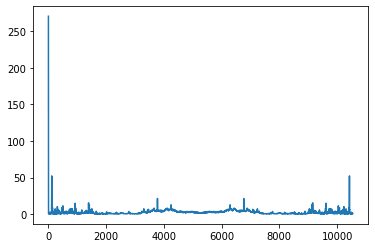

In [ ]:
plt.plot(np.sum(np.abs(t1N_spec_c1),axis=0))

In [ ]:
t1N_fs_c1

array([    0,   112,   113, ..., 10430, 10431, 10432])

In [ ]:
pd.DataFrame(t1N_fs_c1)

,0
0,0
1,112
2,113
3,114
4,115
...,...
2631,10428
2632,10429
2633,10430
2634,10431


In [ ]:
num = pd.Series(np.sum(np.abs(t1B_spec_c1),axis=0))
Q3 = num.quantile(.75)

t1B_fs_c1 = np.where(np.sum(np.abs(t1B_spec_c1),axis=0)>Q3)[0]
len(t1B_fs_c1)

2635

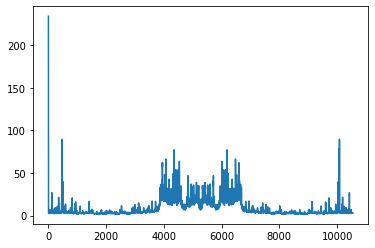

In [ ]:
plt.plot(np.sum(np.abs(t1B_spec_c1),axis=0))

In [ ]:
t1B_fs_c1

array([    0,   117,   118, ..., 10190, 10426, 10427])

In [ ]:
num = pd.Series(np.sum(np.abs(t1U_spec_c1),axis=0))
t1U_spec_c1_np = np.array(t1U_spec_c1)

Q3 = num.quantile(.75)

t1U_fs_c1 = np.where(np.sum(np.abs(t1U_spec_c1),axis=0)>Q3)[0]
len(t1U_fs_c1)

2636

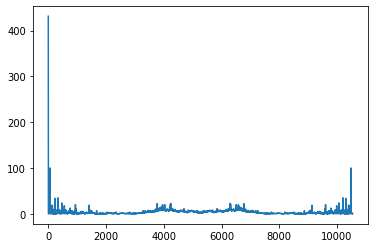

In [ ]:
plt.plot(np.sum(np.abs(t1U_spec_c1),axis=0))

In [ ]:
num = pd.Series(np.sum(np.abs(t1L_spec_c1),axis=0))
Q3 = num.quantile(.75)

t1L_fs_c1 = np.where(np.sum(np.abs(t1L_spec_c1),axis=0)>Q3)[0]
len(t1L_fs_c1)

2636

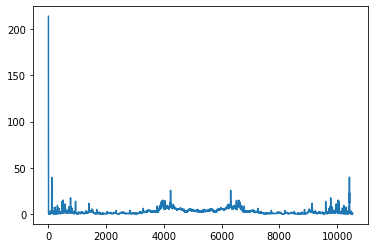

In [ ]:
plt.plot(np.sum(np.abs(t1L_spec_c1),axis=0))

In [ ]:
num = pd.Series(np.sum(np.abs(t1H_spec_c1),axis=0))
Q3 = num.quantile(.75)

t1H_fs_c1 = np.where(np.sum(np.abs(t1H_spec_c1),axis=0)>Q3)[0]
len(t1H_fs_c1)

2636

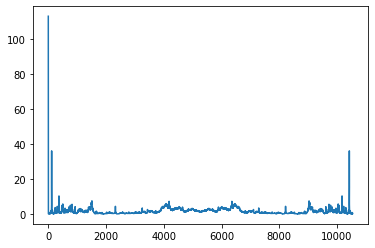

In [ ]:
plt.plot(np.sum(np.abs(t1H_spec_c1),axis=0))

c2

위에서 중요한 변수가 나옴 아래 대략적인 값보다 크게 설정후 중요한 Frequency 대역 추려서 차원 축소하고 그 값을 모델에 학습시키기

In [ ]:
num = pd.Series(np.sum(np.abs(t1N_spec_c2),axis=0))
Q3 = num.quantile(.75)

t1N_fs_c2 = np.where(np.sum(np.abs(t1N_spec_c2),axis=0)>Q3)[0]
len(t1N_fs_c2)

2635

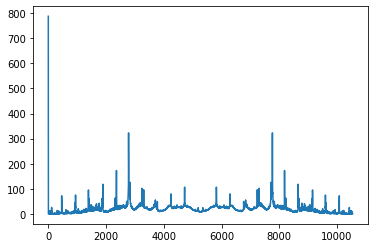

In [ ]:
plt.plot(np.sum(np.abs(t1N_spec_c2),axis=0))

In [ ]:
num = pd.Series(np.sum(np.abs(t1B_spec_c2),axis=0))
Q3 = num.quantile(.75)

t1B_fs_c2 = np.where(np.sum(np.abs(t1B_spec_c2),axis=0)>Q3)[0]
len(t1B_fs_c2)

2636

In [ ]:
num = pd.Series(np.sum(np.abs(t1U_spec_c2),axis=0))
Q3 = num.quantile(.75)

t1U_fs_c2 = np.where(np.sum(np.abs(t1U_spec_c2),axis=0)>Q3)[0]
len(t1U_fs_c2)

2635

In [ ]:
num = pd.Series(np.sum(np.abs(t1L_spec_c2),axis=0))
Q3 = num.quantile(.75)

t1L_fs_c2 = np.where(np.sum(np.abs(t1L_spec_c2),axis=0)>Q3)[0]
len(t1L_fs_c2)

2636

In [ ]:
num = pd.Series(np.sum(np.abs(t1H_spec_c2),axis=0))
Q3 = num.quantile(.75)

t1H_fs_c2 = np.where(np.sum(np.abs(t1H_spec_c2),axis=0)>Q3)[0]
len(t1H_fs_c2)

2636

## Feature Selection

### c1

In [ ]:
df_N_c1 = pd.Series(t1N_fs_c1, name = 'Normal_c1')

In [ ]:
df_B_c1 = pd.Series(t1B_fs_c1, name = 'Bearing_c1')

In [ ]:
df_U_c1 = pd.Series(t1U_fs_c1, name = 'Unbalance_c1')

In [ ]:
df_L_c1 = pd.Series(t1L_fs_c1, name = 'Looseness_c1')

In [ ]:
df_H_c1 = pd.Series(t1H_fs_c1, name = 'High_c1')

In [ ]:
# 열에 대하여 데이터 병합 -> "ignore_index = True"로 인덱스값 나열
df_merge_index_c1 = pd.concat([df_N_c1, df_B_c1, df_U_c1, df_L_c1, df_H_c1],axis = 0, ignore_index=True)
# 내림차순으로 정렬
df_merge_index_c1.sort_values(inplace=True)
# 중복값 삭제
df_merge_index_c1.drop_duplicates(inplace=True)
# 인덱스값 다시 초기화
df_merge_index_c1.reset_index(drop=True, inplace=True)

In [ ]:
df_merge_index_c1

0           0
1          55
2          56
3          57
4          58
        ...  
4555    10485
4556    10486
4557    10487
4558    10488
4559    10489
Length: 4560, dtype: int64

In [ ]:
df_N_c1_v1 = pd.DataFrame(np.sum(np.abs(t1N_spec_c1),axis=0))
df_N_c1_v1 = df_N_c1_v1.loc[df_merge_index_c1,:]

In [ ]:
df_B_c1_v3 = pd.DataFrame(np.sum(np.abs(t1B_spec_c1),axis=0))
df_B_c1_v3 = df_B_c1_v3.loc[df_merge_index_c1,:]

In [ ]:
df_U_c1_v5 = pd.DataFrame(np.sum(np.abs(t1U_spec_c1),axis=0))
df_U_c1_v5 = df_U_c1_v5.loc[df_merge_index_c1,:]

In [ ]:
df_L_c1_v7 = pd.DataFrame(np.sum(np.abs(t1L_spec_c1),axis=0))
df_L_c1_v7 = df_L_c1_v7.loc[df_merge_index_c1,:]

In [ ]:
df_H_c1_v9 = pd.DataFrame(np.sum(np.abs(t1H_spec_c1),axis=0))
df_H_c1_v9 = df_H_c1_v9.loc[df_merge_index_c1,:]

In [ ]:
# 데이터프레임 열방향으로 병합
df_merge_all_c1 = pd.concat([df_N_c1_v1, df_B_c1_v3, df_U_c1_v5, df_L_c1_v7, df_H_c1_v9],axis=1)
# 컬럼명 변경
df_merge_all_c1.columns = ['Normal_c1', 'Bearing_c1', 'Unbalance_c1', 'Looseness_c1', 'High_c1']
df_merge_all_c1

,Normal_c1,Bearing_c1,Unbalance_c1,Looseness_c1,High_c1
0,270.685766,234.113303,431.220619,213.847020,113.049922
55,0.373712,2.985539,5.938353,0.400872,0.238509
56,1.206297,3.053061,7.614432,0.476091,0.262487
57,0.640133,2.980219,10.323287,0.536636,0.272656
58,0.888785,3.431456,16.552953,0.681892,0.329408
...,...,...,...,...,...
10485,2.744004,5.023121,45.301619,1.622700,0.914082
10486,0.888785,3.431456,16.552953,0.681892,0.329408
10487,0.640133,2.980219,10.323287,0.536636,0.272656
10488,1.206297,3.053061,7.614432,0.476091,0.262487


### c2

In [ ]:
df_N_c2 = pd.Series(t1N_fs_c2, name = 'Normal_c2')

In [ ]:
df_B_c2 = pd.Series(t1B_fs_c2, name = 'Bearing_c2')

In [ ]:
df_U_c2 = pd.Series(t1U_fs_c2, name = 'Unbalance_c2')

In [ ]:
df_L_c2 = pd.Series(t1L_fs_c2, name = 'Looseness_c2')

In [ ]:
df_H_c2 = pd.Series(t1H_fs_c2, name = 'High_c2')

In [ ]:
# 열에 대하여 데이터 병합 -> "ignore_index = True"로 인덱스값 나열
df_merge_index_c2 = pd.concat([df_N_c2, df_B_c2, df_U_c2, df_L_c2, df_H_c2],axis = 0, ignore_index=True)
# 내림차순으로 정렬
df_merge_index_c2.sort_values(inplace=True)
# 중복값 삭제
df_merge_index_c2.drop_duplicates(inplace=True)
# 인덱스값 다시 초기화
df_merge_index_c2.reset_index(drop=True, inplace=True)

In [ ]:
df_merge_index_c2

0           0
1          59
2          60
3         116
4         338
        ...  
4153    10190
4154    10206
4155    10428
4156    10484
4157    10485
Length: 4158, dtype: int64

In [ ]:
df_N_c2_v2 = pd.DataFrame(np.sum(np.abs(t1N_spec_c2),axis=0))
df_N_c2_v2 = df_N_c2_v2.loc[df_merge_index_c2,:]

In [ ]:
df_B_c2_v4 = pd.DataFrame(np.sum(np.abs(t1B_spec_c2),axis=0))
df_B_c2_v4 = df_B_c2_v4.loc[df_merge_index_c2,:]

In [ ]:
df_U_c2_v6 = pd.DataFrame(np.sum(np.abs(t1U_spec_c2),axis=0))
df_U_c2_v6 = df_U_c2_v6.loc[df_merge_index_c2,:]

In [ ]:
df_L_c2_v8 = pd.DataFrame(np.sum(np.abs(t1L_spec_c2),axis=0))
df_L_c2_v8 = df_L_c2_v8.loc[df_merge_index_c2,:]

In [ ]:
df_H_c2_v10 = pd.DataFrame(np.sum(np.abs(t1H_spec_c2),axis=0))
df_H_c2_v10 = df_H_c2_v10.loc[df_merge_index_c2,:]

In [ ]:
# 데이터프레임 열방향으로 병합
df_merge_all_c2 = pd.concat([df_N_c2_v2, df_B_c2_v4, df_U_c2_v6, df_L_c2_v8, df_H_c2_v10],axis=1)
# 컬럼명 변경
df_merge_all_c2.columns = ['Normal_c2', 'Bearing_c2', 'Unbalance_c2', 'Looseness_c2', 'High_c2']
df_merge_all_c2

,Normal_c2,Bearing_c2,Unbalance_c2,Looseness_c2,High_c2
0,787.198461,620.778288,1204.516065,767.157578,384.624745
59,6.607232,4.889568,55.085651,5.310355,1.728127
60,13.894356,6.722517,127.467830,10.664130,1.725857
116,26.023848,8.729847,6.036055,8.516827,22.323153
338,10.609249,7.844651,54.944768,1.463937,1.441961
...,...,...,...,...,...
10190,7.083840,29.372036,7.226142,2.525498,1.939307
10206,10.609249,7.844651,54.944768,1.463937,1.441961
10428,26.023848,8.729847,6.036055,8.516827,22.323153
10484,13.894356,6.722517,127.467830,10.664130,1.725857


### 모델링때 사용할 데이터로 만들기

In [ ]:
# 바로 행렬로 볼 수 있음
df_merge_all_c1.values

array([[2.70685766e+02, 2.34113303e+02, 4.31220619e+02, 2.13847020e+02,
        1.13049922e+02],
       [3.73711685e-01, 2.98553918e+00, 5.93835342e+00, 4.00871783e-01,
        2.38508954e-01],
       [1.20629682e+00, 3.05306070e+00, 7.61443202e+00, 4.76090923e-01,
        2.62487341e-01],
       ...,
       [6.40133370e-01, 2.98021910e+00, 1.03232868e+01, 5.36635565e-01,
        2.72655991e-01],
       [1.20629682e+00, 3.05306070e+00, 7.61443202e+00, 4.76090923e-01,
        2.62487341e-01],
       [3.73711685e-01, 2.98553918e+00, 5.93835342e+00, 4.00871783e-01,
        2.38508954e-01]])

In [ ]:
# 라벨값
Label_array = np.array([1, 2, 3, 4, 5])

# 벡터형태로 c1, c2 클래스별로 같이 병합 -> 보통 모델링할때 벡터값으로 변환하여 예측함
array_merge_all = np.vstack([df_merge_all_c1.values,df_merge_all_c2.values])
# 벡터에 라벨값 추가
array_merge_all = np.vstack([array_merge_all, Label_array])
# 행과열 .T로 변환 
array_merge_all = array_merge_all.T

In [ ]:
# 클래스별로 라벨값 붙여주기 1~5
array_merge_all

array([[2.70685766e+02, 3.73711685e-01, 1.20629682e+00, ...,
        1.38943556e+01, 6.60723235e+00, 1.00000000e+00],
       [2.34113303e+02, 2.98553918e+00, 3.05306070e+00, ...,
        6.72251713e+00, 4.88956837e+00, 2.00000000e+00],
       [4.31220619e+02, 5.93835342e+00, 7.61443202e+00, ...,
        1.27467830e+02, 5.50856509e+01, 3.00000000e+00],
       [2.13847020e+02, 4.00871783e-01, 4.76090923e-01, ...,
        1.06641302e+01, 5.31035455e+00, 4.00000000e+00],
       [1.13049922e+02, 2.38508954e-01, 2.62487341e-01, ...,
        1.72585717e+00, 1.72812745e+00, 5.00000000e+00]])

## 학습을 위한 데이터 만들기

### 1초 데이터 임의로 int(len(t1N_spec_c1))개 추출
- 줄이고 싶으면 len()*0.5 이런식으로 값을 넣어서 축소 시킬 것

In [ ]:
print(int(len(t1N_spec_c1)),
int(len(t1B_spec_c1)),
int(len(t1U_spec_c1)),
int(len(t1L_spec_c1)),
int(len(t1H_spec_c1)),
"and",
int(len(t1N_spec_c2)),
int(len(t1B_spec_c2)),
int(len(t1U_spec_c2)),
int(len(t1L_spec_c2)),
int(len(t1H_spec_c2)))

810 812 1209 809 405 and 790 792 1179 789 395


In [ ]:
# 데이터 병합때 열 수가 같아야하므로 데이터가 작은 값으로 랜덤 추출함
import random

t1N_spec_c1_random = random.sample(t1N_spec_c1, int(len(t1N_spec_c2)))
t1B_spec_c1_random = random.sample(t1B_spec_c1, int(len(t1B_spec_c2)))
t1U_spec_c1_random = random.sample(t1U_spec_c1, int(len(t1U_spec_c2)))
t1L_spec_c1_random = random.sample(t1L_spec_c1, int(len(t1L_spec_c2)))
t1H_spec_c1_random = random.sample(t1H_spec_c1, int(len(t1H_spec_c1)))
t1N_spec_c2_random = random.sample(t1N_spec_c2, int(len(t1N_spec_c2)))
t1B_spec_c2_random = random.sample(t1B_spec_c2, int(len(t1B_spec_c2)))
t1U_spec_c2_random = random.sample(t1U_spec_c2, int(len(t1U_spec_c2)))
t1L_spec_c2_random = random.sample(t1L_spec_c2, int(len(t1L_spec_c2)))
t1H_spec_c2_random = random.sample(t1H_spec_c2, int(len(t1H_spec_c1)))

# t1N_spec_c1_random

In [ ]:
t1N_spec_c1_random.shape

(415, 10544)

### 샘플링 데이터 벡터 형태로 데이터 만들기

In [ ]:
t1N_spec_c1_random = np.array(t1N_spec_c1_random)
t1B_spec_c1_random = np.array(t1B_spec_c1_random)
t1U_spec_c1_random = np.array(t1U_spec_c1_random)
t1L_spec_c1_random = np.array(t1L_spec_c1_random)
t1H_spec_c1_random = np.array(t1H_spec_c1_random)

t1N_spec_c2_random = np.array(t1N_spec_c2_random)
t1B_spec_c2_random = np.array(t1B_spec_c2_random)
t1U_spec_c2_random = np.array(t1U_spec_c2_random)
t1L_spec_c2_random = np.array(t1L_spec_c2_random)
t1H_spec_c2_random = np.array(t1H_spec_c2_random)

In [ ]:
df_merge_index_c1.shape

(4350,)

In [ ]:
t1N_spec_c2_random.shape

(415, 10544)

In [ ]:
# 미리 뽑아놓은 인덱스 값으로 차원 축소
#C1
t1N_spec_c1_random_df = pd.DataFrame(t1N_spec_c1_random)
t1N_spec_c1_random_df = t1N_spec_c1_random_df.loc[:,df_merge_index_c1]

t1B_spec_c1_random_df = pd.DataFrame(t1B_spec_c1_random)
t1B_spec_c1_random_df = t1B_spec_c1_random_df.loc[:,df_merge_index_c1]

t1U_spec_c1_random_df = pd.DataFrame(t1U_spec_c1_random)
t1U_spec_c1_random_df = t1U_spec_c1_random_df.loc[:,df_merge_index_c1]

t1L_spec_c1_random_df = pd.DataFrame(t1L_spec_c1_random)
t1L_spec_c1_random_df = t1L_spec_c1_random_df.loc[:,df_merge_index_c1]

t1H_spec_c1_random_df = pd.DataFrame(t1H_spec_c1_random)
t1H_spec_c1_random_df = t1H_spec_c1_random_df.loc[:,df_merge_index_c1]
#C2
t1N_spec_c2_random_df = pd.DataFrame(t1N_spec_c2_random)
t1N_spec_c2_random_df = t1N_spec_c2_random_df.loc[:,df_merge_index_c2]

t1B_spec_c2_random_df = pd.DataFrame(t1B_spec_c2_random)
t1B_spec_c2_random_df = t1B_spec_c2_random_df.loc[:,df_merge_index_c2]

t1U_spec_c2_random_df = pd.DataFrame(t1U_spec_c2_random)
t1U_spec_c2_random_df = t1U_spec_c2_random_df.loc[:,df_merge_index_c2]

t1L_spec_c2_random_df = pd.DataFrame(t1L_spec_c2_random)
t1L_spec_c2_random_df = t1L_spec_c2_random_df.loc[:,df_merge_index_c2]

t1H_spec_c2_random_df = pd.DataFrame(t1H_spec_c2_random)
t1H_spec_c2_random_df = t1H_spec_c2_random_df.loc[:,df_merge_index_c2]

In [ ]:
t1N_spec_c1_random_df

,0,56,57,58,59,60,61,62,63,109,...,10434,10435,10481,10482,10483,10484,10485,10486,10487,10488
0,0.098194-0.000000j,-0.000015+0.000062j,-0.000568-0.000237j,-0.000198-0.000448j,-0.000127-0.001344j,-0.001565+0.004268j,-0.000475+0.000988j,-0.000505+0.000830j,-0.000454+0.000598j,-0.001706+0.002748j,...,-0.001350-0.003187j,-0.001706-0.002748j,-0.000454-0.000598j,-0.000505-0.000830j,-0.000475-0.000988j,-0.001565-0.004268j,-0.000127+0.001344j,-0.000198+0.000448j,-0.000568+0.000237j,-0.000015-0.000062j
1,0.128974+0.000000j,-0.000434-0.002619j,-0.000651+0.000807j,-0.000624+0.001222j,-0.002503+0.005561j,0.000077-0.001854j,-0.000002-0.000587j,0.000167-0.000392j,-0.000140-0.000273j,-0.000151-0.001127j,...,0.000032+0.001956j,-0.000151+0.001127j,-0.000140+0.000273j,0.000167+0.000392j,-0.000002+0.000587j,0.000077+0.001854j,-0.002503-0.005561j,-0.000624-0.001222j,-0.000651-0.000807j,-0.000434+0.002619j
2,0.111343+0.000000j,0.000215+0.003120j,-0.001100-0.000189j,-0.001421-0.000082j,-0.007007+0.001430j,0.000769-0.000595j,0.000230-0.000345j,-0.000074-0.000387j,0.000063-0.000267j,-0.002297-0.004563j,...,-0.001728+0.005288j,-0.002297+0.004563j,0.000063+0.000267j,-0.000074+0.000387j,0.000230+0.000345j,0.000769+0.000595j,-0.007007-0.001430j,-0.001421+0.000082j,-0.001100+0.000189j,0.000215-0.003120j
3,0.106232+0.000000j,0.000240+0.000307j,-0.000871+0.000336j,-0.000359+0.000471j,-0.000804+0.000881j,0.004282-0.002864j,0.000677-0.000188j,0.000463-0.000134j,0.000343-0.000137j,0.001269+0.001571j,...,0.001291-0.001909j,0.001269-0.001571j,0.000343+0.000137j,0.000463+0.000134j,0.000677+0.000188j,0.004282+0.002864j,-0.000804-0.000881j,-0.000359-0.000471j,-0.000871-0.000336j,0.000240-0.000307j
4,0.104006+0.000000j,-0.000489+0.000056j,-0.001007+0.000072j,-0.000856-0.000176j,-0.001336-0.001185j,0.002155+0.003716j,0.000206+0.001068j,-0.000203+0.000799j,-0.000187+0.000805j,-0.001771+0.002782j,...,-0.001483-0.003382j,-0.001771-0.002782j,-0.000187-0.000805j,-0.000203-0.000799j,0.000206-0.001068j,0.002155-0.003716j,-0.001336+0.001185j,-0.000856+0.000176j,-0.001007-0.000072j,-0.000489-0.000056j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,0.093162-0.000000j,-0.000214-0.000045j,0.000333-0.000535j,0.000236-0.000537j,0.000768-0.000743j,-0.003893+0.002250j,-0.001016+0.000312j,-0.000771+0.000140j,-0.000363+0.000252j,-0.002028-0.000452j,...,-0.001676+0.000391j,-0.002028+0.000452j,-0.000363-0.000252j,-0.000771-0.000140j,-0.001016-0.000312j,-0.003893-0.002250j,0.000768+0.000743j,0.000236+0.000537j,0.000333+0.000535j,-0.000214+0.000045j
411,0.096902-0.000000j,-0.000354+0.000755j,0.000352-0.000271j,0.000240+0.000489j,0.000806+0.001116j,-0.004401-0.002879j,-0.001094-0.000386j,-0.000767+0.000007j,-0.000717-0.000116j,-0.002658+0.002167j,...,-0.001995-0.002965j,-0.002658-0.002167j,-0.000717+0.000116j,-0.000767-0.000007j,-0.001094+0.000386j,-0.004401+0.002879j,0.000806-0.001116j,0.000240-0.000489j,0.000352+0.000271j,-0.000354-0.000755j
412,0.100131+0.000000j,0.000362-0.000224j,0.000333-0.000155j,0.000198-0.000441j,0.000084-0.001034j,0.002400+0.004788j,0.000668+0.000914j,0.000694+0.000482j,0.000554+0.000421j,0.002425+0.000297j,...,0.002365-0.000861j,0.002425-0.000297j,0.000554-0.000421j,0.000694-0.000482j,0.000668-0.000914j,0.002400-0.004788j,0.000084+0.001034j,0.000198+0.000441j,0.000333+0.000155j,0.000362+0.000224j
413,0.102979+0.000000j,-0.000439-0.000068j,0.000045-0.000261j,-0.000141-0.000321j,0.000634-0.000415j,-0.004886+0.001623j,-0.001475+0.000171j,-0.001107+0.000028j,-0.001014+0.000110j,-0.002269-0.000052j,...,-0.002389+0.000304j,-0.002269+0.000052j,-0.001014-0.000110j,-0.001107-0.000028j,-0.001475-0.000171j,-0.004886-0.001623j,0.000634+0.000415j,-0.000141+0.000321j,0.000045+0.000261j,-0.000439+0.000068j


In [ ]:
t1N_spec_c2_random_df

,0,59,60,116,117,118,338,354,369,454,...,10084,10090,10175,10190,10206,10426,10427,10428,10484,10485
0,-0.681175-0.000000j,0.001769-0.000783j,0.000747+0.000377j,-0.045887-0.077251j,0.002626+0.003461j,0.000727+0.003276j,-0.001404+0.005656j,0.001132+0.000359j,-0.001395-0.000140j,-0.002656+0.007081j,...,-0.034856-0.007707j,-0.002656-0.007081j,-0.001395+0.000140j,0.001132-0.000359j,-0.001404-0.005656j,0.000727-0.003276j,0.002626-0.003461j,-0.045887+0.077251j,0.000747-0.000377j,0.001769+0.000783j
1,-0.835884+0.000000j,0.000420-0.001129j,-0.000666+0.002536j,-0.000059+0.011667j,0.003586+0.034723j,-0.003767-0.037623j,-0.002041-0.004428j,0.003905+0.001252j,-0.000362-0.001203j,-0.000362+0.001792j,...,0.000711-0.000830j,-0.000362-0.001792j,-0.000362+0.001203j,0.003905-0.001252j,-0.002041+0.004428j,-0.003767+0.037623j,0.003586-0.034723j,-0.000059-0.011667j,-0.000666-0.002536j,0.000420+0.001129j
2,-0.818662-0.000000j,0.006075-0.002714j,-0.000898-0.000440j,-0.007054-0.091371j,0.000021-0.010659j,0.001550-0.006308j,0.001561-0.001530j,0.001603+0.001475j,0.001104-0.003019j,0.014889+0.000328j,...,0.050705+0.016202j,0.014889-0.000328j,0.001104+0.003019j,0.001603-0.001475j,0.001561+0.001530j,0.001550+0.006308j,0.000021+0.010659j,-0.007054+0.091371j,-0.000898+0.000440j,0.006075+0.002714j
3,-0.855719-0.000000j,0.001251-0.000917j,-0.000258+0.002563j,-0.010933-0.001633j,-0.054901-0.002421j,0.023970+0.000979j,-0.001326+0.001430j,0.000733-0.000207j,0.006381+0.001856j,0.006160-0.000841j,...,0.008704+0.010359j,0.006160+0.000841j,0.006381-0.001856j,0.000733+0.000207j,-0.001326-0.001430j,0.023970-0.000979j,-0.054901+0.002421j,-0.010933+0.001633j,-0.000258-0.002563j,0.001251+0.000917j
4,-0.830165-0.000000j,0.000181-0.002338j,-0.000524+0.000015j,0.078976-0.042748j,0.009664-0.006860j,0.003704-0.003244j,0.000799-0.002177j,0.001140-0.001596j,-0.000377+0.000605j,-0.002468-0.006240j,...,-0.026483+0.035094j,-0.002468+0.006240j,-0.000377-0.000605j,0.001140+0.001596j,0.000799+0.002177j,0.003704+0.003244j,0.009664+0.006860j,0.078976+0.042748j,-0.000524-0.000015j,0.000181+0.002338j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,-0.806483-0.000000j,0.002839-0.007010j,0.000103+0.002657j,0.097345-0.002193j,0.008356-0.000654j,0.004495-0.002515j,-0.001095-0.004478j,-0.000529-0.000121j,0.001332+0.000561j,0.012359-0.000881j,...,0.007166-0.008688j,0.012359+0.000881j,0.001332-0.000561j,-0.000529+0.000121j,-0.001095+0.004478j,0.004495+0.002515j,0.008356+0.000654j,0.097345+0.002193j,0.000103-0.002657j,0.002839+0.007010j
411,-0.822390-0.000000j,0.004339+0.005577j,-0.000728-0.002072j,0.039539-0.086627j,0.003062-0.005688j,-0.000480-0.002313j,-0.004377-0.000549j,-0.000691+0.001105j,-0.003018-0.000225j,0.002551+0.004426j,...,-0.011638-0.033933j,0.002551-0.004426j,-0.003018+0.000225j,-0.000691-0.001105j,-0.004377+0.000549j,-0.000480+0.002313j,0.003062+0.005688j,0.039539+0.086627j,-0.000728+0.002072j,0.004339-0.005577j
412,-0.684603+0.000000j,-0.002494-0.001635j,0.000467-0.000188j,-0.084365-0.027578j,0.006547+0.003588j,0.001770+0.001401j,-0.002558+0.003802j,-0.001714-0.000106j,-0.002719+0.001214j,-0.000751-0.000656j,...,-0.000982-0.003063j,-0.000751+0.000656j,-0.002719-0.001214j,-0.001714+0.000106j,-0.002558-0.003802j,0.001770-0.001401j,0.006547-0.003588j,-0.084365+0.027578j,0.000467+0.000188j,-0.002494+0.001635j
413,-0.823777+0.000000j,0.005142+0.004020j,-0.000548-0.000359j,0.008839+0.092859j,0.001853+0.013936j,-0.000091+0.007909j,0.000613-0.000606j,0.001080+0.000042j,-0.000599-0.002375j,0.007161+0.003503j,...,0.020360+0.015895j,0.007161-0.003503j,-0.000599+0.002375j,0.001080-0.000042j,0.000613+0.000606j,-0.000091-0.007909j,0.001853-0.013936j,0.008839-0.092859j,-0.000548+0.000359j,0.005142-0.004020j


In [ ]:
# 라벨값
Label_N = np.ones(int(len(t1N_spec_c2)), dtype=int)

# 벡터형태로 c1, c2 클래스별로 같이 병합 -> 보통 모델링할때 벡터값으로 변환하여 예측함
data_sampling_N = np.vstack([t1N_spec_c1_random_df.values.T,t1N_spec_c2_random_df.values.T])
# 벡터에 라벨값 추가
data_sampling_N = np.vstack([data_sampling_N, Label_N])
# 행과열 .T로 변환 
data_sampling_N = data_sampling_N.T

In [ ]:
data_sampling_N.shape

(415, 9066)

In [ ]:
pd.DataFrame(data_sampling_N)

,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
0,0.098194-0.000000j,-0.000015+0.000062j,-0.000568-0.000237j,-0.000198-0.000448j,-0.000127-0.001344j,-0.001565+0.004268j,-0.000475+0.000988j,-0.000505+0.000830j,-0.000454+0.000598j,-0.001706+0.002748j,...,-0.002656-0.007081j,-0.001395+0.000140j,0.001132-0.000359j,-0.001404-0.005656j,0.000727-0.003276j,0.002626-0.003461j,-0.045887+0.077251j,0.000747-0.000377j,0.001769+0.000783j,1.0+0.0j
1,0.128974+0.000000j,-0.000434-0.002619j,-0.000651+0.000807j,-0.000624+0.001222j,-0.002503+0.005561j,0.000077-0.001854j,-0.000002-0.000587j,0.000167-0.000392j,-0.000140-0.000273j,-0.000151-0.001127j,...,-0.000362-0.001792j,-0.000362+0.001203j,0.003905-0.001252j,-0.002041+0.004428j,-0.003767+0.037623j,0.003586-0.034723j,-0.000059-0.011667j,-0.000666-0.002536j,0.000420+0.001129j,1.0+0.0j
2,0.111343+0.000000j,0.000215+0.003120j,-0.001100-0.000189j,-0.001421-0.000082j,-0.007007+0.001430j,0.000769-0.000595j,0.000230-0.000345j,-0.000074-0.000387j,0.000063-0.000267j,-0.002297-0.004563j,...,0.014889-0.000328j,0.001104+0.003019j,0.001603-0.001475j,0.001561+0.001530j,0.001550+0.006308j,0.000021+0.010659j,-0.007054+0.091371j,-0.000898+0.000440j,0.006075+0.002714j,1.0+0.0j
3,0.106232+0.000000j,0.000240+0.000307j,-0.000871+0.000336j,-0.000359+0.000471j,-0.000804+0.000881j,0.004282-0.002864j,0.000677-0.000188j,0.000463-0.000134j,0.000343-0.000137j,0.001269+0.001571j,...,0.006160+0.000841j,0.006381-0.001856j,0.000733+0.000207j,-0.001326-0.001430j,0.023970-0.000979j,-0.054901+0.002421j,-0.010933+0.001633j,-0.000258-0.002563j,0.001251+0.000917j,1.0+0.0j
4,0.104006+0.000000j,-0.000489+0.000056j,-0.001007+0.000072j,-0.000856-0.000176j,-0.001336-0.001185j,0.002155+0.003716j,0.000206+0.001068j,-0.000203+0.000799j,-0.000187+0.000805j,-0.001771+0.002782j,...,-0.002468+0.006240j,-0.000377-0.000605j,0.001140+0.001596j,0.000799+0.002177j,0.003704+0.003244j,0.009664+0.006860j,0.078976+0.042748j,-0.000524-0.000015j,0.000181+0.002338j,1.0+0.0j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,0.093162-0.000000j,-0.000214-0.000045j,0.000333-0.000535j,0.000236-0.000537j,0.000768-0.000743j,-0.003893+0.002250j,-0.001016+0.000312j,-0.000771+0.000140j,-0.000363+0.000252j,-0.002028-0.000452j,...,0.012359+0.000881j,0.001332-0.000561j,-0.000529+0.000121j,-0.001095+0.004478j,0.004495+0.002515j,0.008356+0.000654j,0.097345+0.002193j,0.000103-0.002657j,0.002839+0.007010j,1.0+0.0j
411,0.096902-0.000000j,-0.000354+0.000755j,0.000352-0.000271j,0.000240+0.000489j,0.000806+0.001116j,-0.004401-0.002879j,-0.001094-0.000386j,-0.000767+0.000007j,-0.000717-0.000116j,-0.002658+0.002167j,...,0.002551-0.004426j,-0.003018+0.000225j,-0.000691-0.001105j,-0.004377+0.000549j,-0.000480+0.002313j,0.003062+0.005688j,0.039539+0.086627j,-0.000728+0.002072j,0.004339-0.005577j,1.0+0.0j
412,0.100131+0.000000j,0.000362-0.000224j,0.000333-0.000155j,0.000198-0.000441j,0.000084-0.001034j,0.002400+0.004788j,0.000668+0.000914j,0.000694+0.000482j,0.000554+0.000421j,0.002425+0.000297j,...,-0.000751+0.000656j,-0.002719-0.001214j,-0.001714+0.000106j,-0.002558-0.003802j,0.001770-0.001401j,0.006547-0.003588j,-0.084365+0.027578j,0.000467+0.000188j,-0.002494+0.001635j,1.0+0.0j
413,0.102979+0.000000j,-0.000439-0.000068j,0.000045-0.000261j,-0.000141-0.000321j,0.000634-0.000415j,-0.004886+0.001623j,-0.001475+0.000171j,-0.001107+0.000028j,-0.001014+0.000110j,-0.002269-0.000052j,...,0.007161-0.003503j,-0.000599+0.002375j,0.001080-0.000042j,0.000613+0.000606j,-0.000091-0.007909j,0.001853-0.013936j,0.008839-0.092859j,-0.000548+0.000359j,0.005142-0.004020j,1.0+0.0j


In [ ]:
# 라벨값
Label_B = np.full(int(len(t1B_spec_c2)), 2, dtype=int)

# 벡터형태로 c1, c2 클래스별로 같이 병합 -> 보통 모델링할때 벡터값으로 변환하여 예측함
data_sampling_B = np.vstack([t1B_spec_c1_random_df.values.T,t1B_spec_c2_random_df.values.T])
# 벡터에 라벨값 추가
data_sampling_B = np.vstack([data_sampling_B, Label_B])
# 행과열 .T로 변환 
data_sampling_B = data_sampling_B.T

In [ ]:
# 라벨값
Label_U = np.full(int(len(t1U_spec_c2)), 3, dtype=int)

# 벡터형태로 c1, c2 클래스별로 같이 병합 -> 보통 모델링할때 벡터값으로 변환하여 예측함
data_sampling_U = np.vstack([t1U_spec_c1_random_df.values.T,t1U_spec_c2_random_df.values.T])
# 벡터에 라벨값 추가
data_sampling_U = np.vstack([data_sampling_U, Label_U])
# 행과열 .T로 변환 
data_sampling_U = data_sampling_U.T

In [ ]:
# 라벨값
Label_L = np.full(int(len(t1L_spec_c2)), 4, dtype=int)

# 벡터형태로 c1, c2 클래스별로 같이 병합 -> 보통 모델링할때 벡터값으로 변환하여 예측함
data_sampling_L = np.vstack([t1L_spec_c1_random_df.values.T,t1L_spec_c2_random_df.values.T])
# 벡터에 라벨값 추가
data_sampling_L = np.vstack([data_sampling_L, Label_L])
# 행과열 .T로 변환 
data_sampling_L = data_sampling_L.T

In [ ]:
# 라벨값
Label_H = np.full(int(len(t1H_spec_c1)), 5, dtype=int)

# 벡터형태로 c1, c2 클래스별로 같이 병합 -> 보통 모델링할때 벡터값으로 변환하여 예측함
data_sampling_H = np.vstack([t1H_spec_c1_random_df.values.T,t1H_spec_c2_random_df.values.T])
# 벡터에 라벨값 추가
data_sampling_H = np.vstack([data_sampling_H, Label_H])
# 행과열 .T로 변환 
data_sampling_H = data_sampling_H.T

In [ ]:
# 데이터 전체 병합
data_sampling = np.vstack([data_sampling_N, data_sampling_B, data_sampling_U, data_sampling_L, data_sampling_H])

In [ ]:
# scikit learn 라이브러리가 복소수를 지원하지 않아 디버깅 발생함
# 복소수를 실수 형태로 변형하는 코드임
data_sampling = np.real(data_sampling)

In [ ]:
data_sampling

array([[ 9.81942081e-02, -1.54315700e-05, -5.68493903e-04, ...,
         7.47110450e-04,  1.76911211e-03,  1.00000000e+00],
       [ 1.28973883e-01, -4.33656178e-04, -6.50812624e-04, ...,
        -6.66489421e-04,  4.20182404e-04,  1.00000000e+00],
       [ 1.11343037e-01,  2.15482823e-04, -1.10028746e-03, ...,
        -8.97719766e-04,  6.07462140e-03,  1.00000000e+00],
       ...,
       [ 2.93342905e-01,  5.52004684e-04,  1.93864395e-04, ...,
         4.92546794e-03, -3.15866056e-03,  5.00000000e+00],
       [ 2.84307413e-01, -6.19772954e-04, -7.22433211e-04, ...,
        -1.47383991e-03, -3.47112174e-05,  5.00000000e+00],
       [ 2.84556878e-01, -3.60232594e-04, -4.95642540e-04, ...,
        -2.99518897e-03,  7.15460373e-03,  5.00000000e+00]])

In [ ]:
data_sampling.shape

(2064, 9066)

## 모델링

In [ ]:
from sklearn.model_selection import train_test_split

X = data_sampling[:, :-1]
y = data_sampling[:, -1]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
# 하이퍼 파라미터 튜닝 더 알아보기
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np

# from sklearn.metrics import f1_score, make_scorer
# f1 = make_scorer(f1_score , average='macro')

# #define the parameters grid
# param_grid = {'max_depth': np.arange(3, 8),
#              'criterion' : ['gini','entropy'],
#              'max_leaf_nodes': [5,10,20,50],
#              'min_samples_split': [2, 5, 10, 20]}

# #create the grid
# grid_tree = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, scoring= 'f1')
# #the cv option will be clear in a few cells

# #training
# grid_tree.fit(x_train, y_train)
# #let's see the best estimator
# print(grid_tree.best_estimator_)
# #with its score
# print(np.abs(grid_tree.best_score_))

위 출력 코드
RandomForestClassifier(max_depth=3, max_leaf_nodes=5)
nan

In [ ]:
# random_state는 시드값을 고정해줌
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)

model.fit(x_train, y_train)
model_pred = model.predict(x_test)

Accuracy: 0.31809804644305195
F1-Score: 0.3181
              precision    recall  f1-score   support

     Bearing       0.00      0.00      0.00      1800
   Looseness       0.27      1.00      0.42       609
      Normal       0.00      0.00      0.00      1485
   Unbalance       0.38      1.00      0.55      1117
        high       0.00      0.00      0.00       415

    accuracy                           0.32      5426
   macro avg       0.13      0.40      0.19      5426
weighted avg       0.11      0.32      0.16      5426



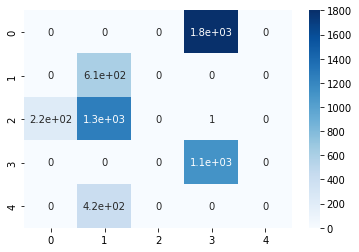

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

accuracy = model.score(x_test, y_test)
print("Accuracy:", accuracy)
# f1-score에서 average가 binary로 디폴트 설정 되어 있는데 이것은 이진분류에 적합하여 micro로 바꿔 다중 클래스 분류를 해줌
f1 = f1_score(y_test, model_pred, average='micro')
print("F1-Score: {:.4f}".format(f1))
print(classification_report(y_test, model_pred))

cm = pd.DataFrame(confusion_matrix(y_test, model_pred))
sns.heatmap(cm, annot=True, cmap='Blues')

      Feature  Importance
0           0    0.038000
4350     4350    0.033888
4351     4351    0.011735
4352     4352    0.008115
6           6    0.007164
...       ...         ...
5456     5456    0.000000
5457     5457    0.000000
5460     5460    0.000000
5461     5461    0.000000
4532     4532    0.000000

[9065 rows x 2 columns]


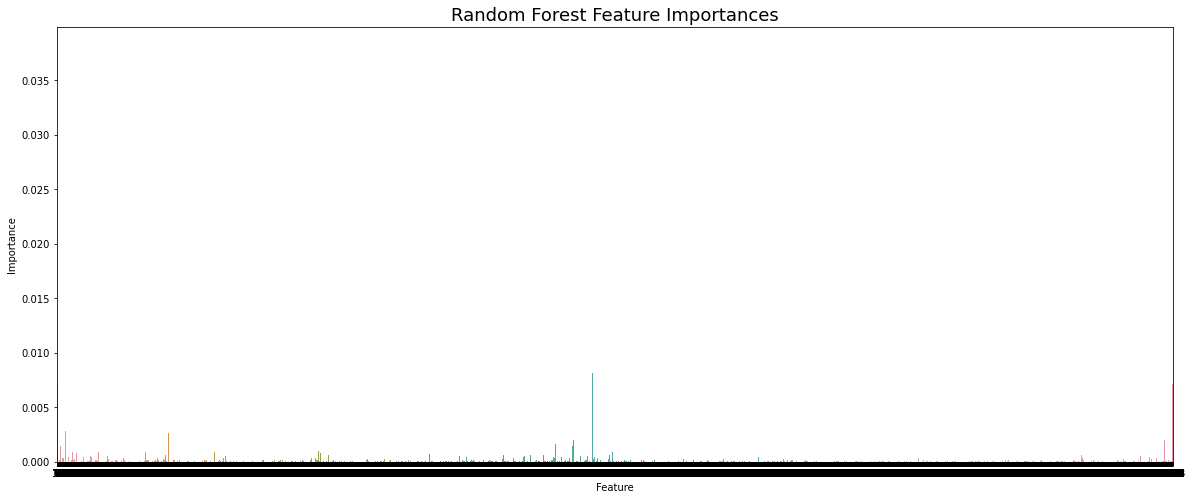

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances 평가

# 어레이 형태 다시 데이터 프레임으로 전환
x_train_df = pd.DataFrame(x_train)

importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': x_train_df.columns, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df)

# 특성 중요도 시각화 -> Feature들이 왜 그런진 모르겠지만 오름차순 정렬이 안됨
plt.figure(figsize=(20, 8))
sns.barplot(x='Feature', y='Importance', data = importance_df)
plt.title('Random Forest Feature Importances', fontsize=18)
plt.show()

## 2, 3일차 데이터 특징 분석

In [ ]:
day23_data

defaultdict(list,
            {'Bearing': array([[2.18429991e-01, 2.86182839e-03, 8.20591198e-04, ...,
                     9.55451898e-03, 7.16568605e-03, 8.93325014e-04],
                    [2.14143473e-01, 2.65980603e-04, 1.93758614e-04, ...,
                     1.37461224e-03, 1.11575927e-03, 6.65773185e-03],
                    [2.14219414e-01, 5.53884659e-04, 4.26533471e-04, ...,
                     3.56512828e-03, 1.16417784e-02, 1.20638381e-03],
                    ...,
                    [1.84079944e-01, 4.50912644e-04, 4.74629020e-04, ...,
                     2.22663494e-02, 1.81688517e-02, 1.37181469e-02],
                    [1.84103299e-01, 2.23653581e-04, 1.95291878e-04, ...,
                     8.49213950e-03, 2.01549038e-02, 1.26879214e-02],
                    [1.83989457e-01, 2.02133452e-04, 1.55337081e-04, ...,
                     1.88920895e-02, 2.34009709e-03, 1.09636557e-02]]),
             'Looseness': array([[9.94589556e-02, 5.52670009e-04, 4.41244696e-04

In [ ]:
day23_data['Normal'].shape

(5017, 10544)

In [ ]:
day23_data['Bearing'].shape

(3890, 10544)

In [ ]:
day23_data['Unbalance'].shape

(5092, 10544)

In [ ]:
day23_data['Looseness'].shape

(3069, 10544)

In [ ]:
day1_data['Normal'].shape

(1485, 10544)

In [ ]:
day1_data['Bearing'].shape

(1800, 10544)

In [ ]:
day1_data['Unbalance'].shape

(1117, 10544)

In [ ]:
day1_data['Looseness'].shape

(609, 10544)

In [ ]:
day1_data['high'].shape

(415, 10544)

In [ ]:
get_fft_dict(['1st_Normal'])

Normal


1485it [00:26, 56.60it/s]


defaultdict(list,
            {'Normal': array([[1.09580421e-01, 2.48523732e-04, 2.90716417e-04, ...,
                     1.35898856e-02, 1.34342145e-02, 5.58731363e-03],
                    [1.11261997e-01, 2.07214361e-04, 8.80259555e-05, ...,
                     4.81528974e-03, 7.44121423e-03, 1.14746629e-02],
                    [1.15813414e-01, 2.43674842e-03, 1.07876787e-04, ...,
                     3.43994208e-03, 4.94164566e-03, 1.14538146e-02],
                    ...,
                    [1.04029616e-01, 3.88214232e-04, 2.51818352e-04, ...,
                     6.48262315e-03, 1.29243226e-02, 9.03369913e-03],
                    [1.04333903e-01, 1.54657019e-04, 2.43291263e-04, ...,
                     5.33289495e-02, 2.88013429e-02, 1.40665386e-02],
                    [1.07397912e-01, 1.67042753e-03, 9.86070670e-04, ...,
                     3.23268864e-02, 2.10531966e-02, 2.70858936e-02]])})

In [ ]:
get_fft_dict(['1st_Normal'])['Normal']

Normal


1485it [00:22, 64.76it/s]


array([[1.09580421e-01, 2.48523732e-04, 2.90716417e-04, ...,
        1.35898856e-02, 1.34342145e-02, 5.58731363e-03],
       [1.11261997e-01, 2.07214361e-04, 8.80259555e-05, ...,
        4.81528974e-03, 7.44121423e-03, 1.14746629e-02],
       [1.15813414e-01, 2.43674842e-03, 1.07876787e-04, ...,
        3.43994208e-03, 4.94164566e-03, 1.14538146e-02],
       ...,
       [1.04029616e-01, 3.88214232e-04, 2.51818352e-04, ...,
        6.48262315e-03, 1.29243226e-02, 9.03369913e-03],
       [1.04333903e-01, 1.54657019e-04, 2.43291263e-04, ...,
        5.33289495e-02, 2.88013429e-02, 1.40665386e-02],
       [1.07397912e-01, 1.67042753e-03, 9.86070670e-04, ...,
        3.23268864e-02, 2.10531966e-02, 2.70858936e-02]])

In [ ]:
get_fft_dict(['1st_Normal'])['Normal'].shape

Normal


1485it [00:42, 34.62it/s]


(1485, 10544)

Normal


1485it [00:25, 58.26it/s]


 ...]

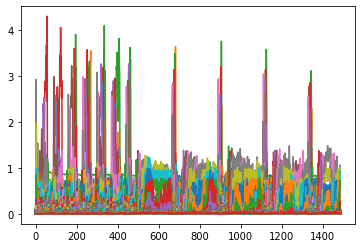

In [ ]:
fig, ax = plt.subplots()

ax.plot(get_fft_dict(['1st_Normal'])['Normal'], label='Normal')
plt.show()

Normal


1485it [00:27, 54.94it/s]


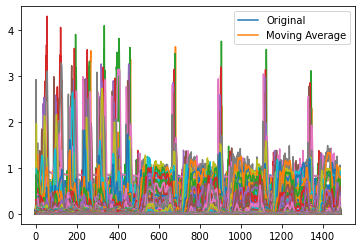

In [ ]:
N1_df = pd.DataFrame(get_fft_dict(['1st_Normal'])['Normal'])

ma_N1_df = N1_df.rolling(window=10).mean()

fig, ax = plt.subplots()
N1_df.plot(ax=ax, legend=False)
ma_N1_df.plot(ax=ax, legend=False)

ax.legend(['Original', 'Moving Average'])
plt.show()

In [ ]:
# 이동 평균을 구합니다. window는 이동 평균 구간의 크기를 나타냅니다.
window_size = 100
ma_N1_df = np.convolve(N1_df, np.ones(window_size) / window_size, mode='valid')

# 그래프 출력
fig, ax = plt.subplots()

# 원본 데이터를 그립니다.
for i in range(N1_df.shape[0]):
    ax.plot(N1_df[i], alpha=0.2, color='gray')

# 이동 평균 데이터를 그립니다.
ax.plot(ma_N1_df, color='red')

# 그래프 제목과 라벨 추가
ax.set_title('Moving Average')
ax.set_xlabel('Time')
ax.set_ylabel('Value')

# 범례 추가
ax.legend(['Original', 'Moving Average'])

# 그래프 출력
plt.show()

ValueError: ignored

In [ ]:
fig, ax = plt.subplots()

ax.plot(get_fft_dict(['1st_Normal'])['Normal'], label='Normal')
ax.plot(, label='Bearing')
ax.plot(, label='Unbalance')
ax.plot(, label='Looseness')
ax.plot(, label='High')

In [ ]:
# 이동 평균을 구합니다. window는 이동 평균 구간의 크기를 나타냅니다.
window_size = 1
N3_df = pd.DataFrame(get_fft_dict(['3rd_Normal'])['Normal'])
ma_N3_df = np.apply_along_axis(lambda m: np.convolve(m, np.ones(window_size) / window_size, mode='valid'), axis=1, arr=N3_df)

# 그래프 출력
fig, ax = plt.subplots(figsize=(50, 12))

# 원본 데이터를 그립니다.
for i in range(N3_df.shape[0]):
    ax.plot(N3_df[i], alpha=0.2, color='blue')

# 이동 평균 데이터를 그립니다.
ax.plot(ma_N3_df, color='red')

# 그래프 제목과 라벨 추가
ax.set_title('Moving Average')

# 범례 추가
ax.legend(['Original', 'Moving Average'])

# 그래프 출력
plt.show()